This is a cleaned-up version of my data exploration notebook. Things were starting to get cluttered in the other one.

### Potential Inquiries
* See where properties with multiple transactions gained and lost value --> (How many houses, how much value, by town, over different periods of time)
* Foreclosures-- where and when have there been a lot?
* Building of new developments? (Might be shown by selling many houses in a short period of time on a new road)
* Signs of house flipping, i.e. a purchase and a sale for significantly more within a short period
* Has recovery been different for different segments of the market (different price-range houses)?
* Are there observable effects of the crumbling fundations in the northeastern part of CT?

### Calculations
* Adjust sales prices for inflation/season -- there is a Python package for seasonal adjustment
* Take a close look at the assessment column
* Each town's assessment rate, or look at a hosue's sale ratio relative to its town only
* Distribution of house prices in given towns, or on given streets
* Town-by-town medians, ranges

In [317]:
import pandas as pd
import matplotlib
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Update MAX_YEAR when new data comes out.

In [318]:
MIN_YEAR = 2001
MAX_YEAR = 2016 # update this when new data comes out

#### Load in the clean data

In [319]:
def pull_out_recorded_year_and_month(df):
    """
    Returns a copy of df with columns Month and Year, which are extracted from DateRecorded.
    """
    new_df = df.copy()
    new_df['Year'] = new_df['DateRecorded'].str[6:10]
    new_df['Month'] = new_df['DateRecorded'].str[0:2]
    
    #new_df['Year'] = new_df['Year'].astype(int)
    
    return new_df

In [320]:
def combine_data_into_master_df():
    """
    Returns a DataFrame which combines all of the clean CSVs for each year.
    """
    # Combine the year-by-year clean csvs, which are located at 'data/clean_data_20xx_listings.csv'
    df = pd.read_csv('data/clean_data_' + str(MIN_YEAR) + '_listings.csv')
    for year in range(MIN_YEAR+1, MAX_YEAR+1):
        df = df.append(pd.read_csv('data/clean_data_' + str(year) + '_listings.csv'))

    # Now remove the index column
    #df = df.drop('Unnamed: 0', 1)
    return pull_out_recorded_year_and_month(df) # Pull out month, year of DateRecorded and return

In [377]:
def split_up_daterecorded(df):
    """
    Returns a copy of df with additional columns, 'Year', 'Month', and 'YearMonth' which are extracted from
    DateRecorded. We will use these columns to distinguish between ListYear (the year in which a propety was LISTED)
    and DateRecorded (the date and time when a sale occurred.
    """
    new_df = df.copy()
    
    # Split up DateRecorded
    new_df['Year'] = new_df['DateRecorded'].str[6:10]
    new_df['Month'] = new_df['DateRecorded'].str[0:2]
    new_df['YearMonth'] = new_df['Year'] + '-' + new_df['Month']
    
    return new_df

In [378]:
df = split_up_daterecorded(combine_data_into_master_df())

In [379]:
df.head()

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks,Year,Month,YearMonth
0,684,10173,2001,04/17/2002 12:00:00 AM,Ansonia,1-3 EAGLE STREET,63630,116000.000,54.853,Residential,Two Family,0,NaN,2002,04,2002-04
1,694,10005,2001,10/04/2001 12:00:00 AM,Ansonia,1 CRESTWOOD ROAD,76370,160000.000,47.731,Residential,Single Family,0,NaN,2001,10,2001-10
2,697,10253,2001,06/18/2002 12:00:00 AM,Ansonia,1 DAVIES CT,97720,180000.000,54.289,Residential,Single Family,0,NaN,2002,06,2002-06
3,698,10094,2001,01/17/2002 12:00:00 AM,Ansonia,1 DOREL TERRACE,110600,259900.000,42.555,Residential,Single Family,0,NaN,2002,01,2002-01
4,710,10100,2001,01/30/2002 12:00:00 AM,Ansonia,1 JAMES STREET,63210,132000.000,47.886,Residential,Single Family,0,NaN,2002,01,2002-01


### Notes on the data frames
* Use DataFrame 'df' if you want to look at ALL of the clean data
* Use 'use_df' if you want to just look at the rows that don't have NonUseCodes. You should use use_df if you are calculating any statistics.
* Use 'res_df' if you want to look at RESIDENTIAL properties (but not condos or apartments) that don't have NonUseCodes. Best way to standardize.

In [380]:
def get_residential(df):
    """
    Returns just the residential properties.
    """
    return df[df['PropertyType'] == 'Residential']

In [381]:
def get_single_family_residential(df):
    """
    Returns just the single family residential properties.
    """
    res = get_residential(df)
    return res[res['ResidentialType'] == 'Single Family']

In [382]:
def get_commercial(df):
    """
    Returns just the commercial properties.
    """
    return df[df['PropertyType'] == 'Commercial']

In [383]:
use_df = df[df['NonUseCode'] < 1]
res_df = get_single_family_residential(use_df)

# Add the extra columns
use_df = split_up_daterecorded(use_df)
res_df = split_up_daterecorded(res_df)

### Calculate town-by-town statistics

#### Dataframes:
* town_df for all residential properties without NonUseCodes in time range MINYEAR - MAXYEAR

In [347]:
def get_all_town_names():
    """ Returns a pandas Series of all town names, plus 'Connecticut' at the top. In alphabetical order otherwise. """
    all_towns = list(df['Town'].unique())
    all_towns = ['Connecticut'] + all_towns
    
    return pd.Series(all_towns)

In [400]:
def create_new_town_df():
    """
    Returns a new dataframe where each row is a town. The column values are all NaN.
    """
    columns = ['PeakSaleAmount']
    return pd.DataFrame(columns=columns, index=get_all_town_names())

In [401]:
town_df = create_new_town_df()

In [437]:
def calculate_town_peak_saleamount_before_recession(town='Connecticut', source_df=res_df):
    """
    Returns the peak SaleAmount for 'town' before the recession (which I mark at 2008).
    Grabs all sales for 'town' from source_df.
    """
    subset = source_df
    
    # Subset by town 
    if town != 'Connecticut':
        subset = source_df[source_df['Town'] == town]

    # Generate a list of medians
    yearly_medians = []
    for year in range(MIN_YEAR, 2008):
        years_median = subset[subset['Year'] == str(year)]['SaleAmount'].median()
        yearly_medians += [years_median]
   
    # Return peak MEDIAN sale amount
    return max(yearly_medians)

In [438]:
def fill_in_town_df(df, source_df=res_df):
    """
    df should be a blank town dataframe. You can simply pass create_new_town_df() if you want.
    Uses source_df's numbers to calculate values to fill in df.
    """
    filled_df = df.copy()
    
    for town in filled_df.index:
        filled_df.loc[town, 'PeakSaleAmount'] = calculate_town_peak_saleamount_before_recession(town, source_df)
    
    return filled_df

In [439]:
town_df = fill_in_town_df(create_new_town_df())

In [443]:
town_df.head(6)

,PeakSaleAmount
Connecticut,315000.000
Ansonia,250000.000
Ashford,270000.000
Avon,505000.000
Barkhamsted,275000.000
Berlin,277000.000


### Timeseries functionality
Should be able to make timeseries for individual towns and all towns on:
* Median of any column
* Number sold in each year

#### Median timeseries

In [415]:
def get_years_median(column, year, town='Connecticut', source_df=res_df):
    """
    Returns the median value of column for town from year, using data from source_df, as a list.
    This is a HELPER FUNCTION for median_timeseries()
    """
    subset = source_df[source_df['Year'] == str(year)]
    
    # Subset by a specific town
    if town != 'Connecticut':
        # Get the rows for this town in the given year
        subset = subset[subset['Town'] == town]

    # Calculate and return the median
    median = subset[column].median()
    if median == 'nan':
        return -1
    else:
        return median

In [322]:
def median_timeseries(column, town='Connecticut', startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series for a particular town and column, from start year to endyear.
    Values are the median of column.
    Grabs the data from source_df.
    """
    # Make the DataFrame's attributes
    index = list(range(startyear, endyear+1))
    columns = [town]
    
    # Generate a list of medians using helper function
    list_of_medians = []
    for year in index:
        list_of_medians.append(get_years_median(column, year, town))
        
    return pd.DataFrame(data=list_of_medians, index=index, columns=columns)

In [323]:
def median_timeseries_all_towns(column, startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series of all towns in CT, as well as the CT average.
    Each column is a year with values being the median of 'column' for that town in that year.
    """
    # Make the DataFrame's attributes
    columns = list(range(startyear, endyear+1))
    time_series = pd.DataFrame(columns=columns, data = median_timeseries(column).transpose())
    
    # Add in the info for each town
    for town in source_df['Town'].unique():
        time_series = pd.concat([time_series, median_timeseries(column, town).transpose()])
        
    # Add in town name column
    time_series['Town'] = time_series.index
            
    return time_series

In [325]:
# Save the saleamount timeseries for all towns for use later.
saleamount_ts_all = median_timeseries_all_towns('SaleAmount')

KeyboardInterrupt: 

In [ ]:
%save saleamount_ts_all

In [ ]:
saleamount_ts_all.head()

#### Number sold time series

In [ ]:
def get_years_sale_count(year, town='Connecticut', source_df=res_df):
    """
    Returns the nummber of sales in one town from year, using data from source_df, as a list.
    This is a HELPER FUNCTION for sale_count_timeseries().
    """
    # Subset by town and year
    subset = source_df[source_df['Year'] == str(year)]
    if town != 'Connecticut':
        subset = subset[subset['Town'] == town]

    # Calculate and return the length
    count = len(subset)
    if count == 'nan':
        return -1
    else:
        return count

In [ ]:
def sale_count_timeseries(town='Connecticut', startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series for a particular town and column, from start year to endyear.
    Values are the number of sales in that town in that year.
    Grabs the data from source_df.
    """
    # Make the DataFrame's attributes
    index = list(range(startyear, endyear+1))
    columns = [town]
    
    # Generate a list of medians using helper function
    list_of_sale_counts = []
    for year in index:
        list_of_sale_counts.append(get_years_sale_count(year, town))
        
    return pd.DataFrame(data=list_of_sale_counts, index=index, columns=columns)

In [ ]:
def sale_count_timeseries_all_towns(startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series of all towns in CT, as well as the CT average.
    Each column is a year with values being the number of homes sold in that town in that year.
    """
    # Make the DataFrame's attributes
    columns = list(range(startyear, endyear+1))
    time_series = pd.DataFrame(columns=columns, data = sale_count_timeseries('Connecticut', startyear, endyear).transpose())
    
    for town in source_df['Town'].unique():
        time_series = pd.concat([time_series, sale_count_timeseries(town, startyear, endyear).transpose()])
            
    return time_series

In [ ]:
sale_count_ts_all_towns = sale_count_timeseries_all_towns()

In [ ]:
%store sale_count_ts_all_towns

### Fact check your SaleAmount medians and NumberSold

#### Cross-check median sale amount with Warren Group:
"A total of 3,829 single-family homes were sold in Connecticut during the month of August, compared with 3,776 sold in August 2016... Meanwhile, the median price of a single-family home increased 1.9 percent in August to \$265,000, compared with __\$260,000__ a year ago." from https://thewarrengroup.com/2017/09/26/conn-single-family-edge-higher-in-august/

In [32]:
aug_2016 = res_df[(res_df['Year'] == '2016') & (res_df['Month'] == '08')]
print("Number of single family homes sold in August 2016: " + str(get_years_sale_count(2016, 'Connecticut', source_df = aug_2016)))

Number of single family homes sold in August 2016: 3408


In [33]:
print("August 2016 sale price median: " + str(get_years_median('SaleAmount', 2016, 'Connecticut', source_df = aug_2016)))

August 2016 sale price median: 255000.0


__Another Warren Group example:__
"A total of 2,139 single-family homes sold in Connecticut during the month \[of March, 2016\] compared with 1,768 sold in March 2015... The median price of a single-family home fell by 3 percent in March to \$225,000 compared with \$232,000 a year ago."
from https://thewarrengroup.com/2016/05/10/connecticut-home-sales-continue-torrid-pace-in-march/

In [34]:
mar_2015 = res_df[(res_df['Year'] == '2015') & (res_df['Month'] == '03')]
print("Number of homes sold in March 2015: " + str(get_years_sale_count(2015, 'Connecticut', source_df = mar_2015)))

Number of homes sold in March 2015: 2929


In [35]:
# WG calculates median from March 2015 to March 2016
mar_15_on = res_df[(res_df['Year'] == '2015') & (res_df['Month'].isin(['03', '04', '05', '06', '07', '08', '09',
                                                                      '10', '11', '12']))]
up_to_mar_16 = res_df[(res_df['Year'] == '2016') & (res_df['Month'].isin(['01', '02', '03']))]
mar_15_to_mar_16 = pd.concat([mar_15_on, up_to_mar_16])

print("Median price from March to March: " + str(mar_15_to_mar_16['SaleAmount'].median()))

Median price from March to March: 225000.0


#### Cross-check median sale price and  number sold with CTRealtors:
"Connecticut REALTORS® reports that the single-family residential home median sales price is \$237,000 *which
reflects a 3.1 percent increase* from \$229,900 in that same time period last year. Median indicates that half the
homes sold for more and half for less. Single-family residential home sales in Connecticut increased 5.1 percent
comparing March 2017 to March 2016. The total units of homes sold were 2,527 in March 2017 and 2,404 in
March 2016." from https://www.ctrealtors.com/Customer-Content/www/press-releases/PDFs/Stats-2017March.pdf

In [36]:
mar_2016 = res_df[(res_df['Year'] == '2016') & (res_df['Month'] == '03')]
print("March 2016 sale price median: " + str(get_years_median('SaleAmount', 2016, 'Connecticut', source_df = mar_2016)))

March 2016 sale price median: 233750.0


In [37]:
mar_2016_single_family_homes = res_df[(res_df['Year'] == '2016') & (res_df['Month'] == '03')]
print("Single family homes: " + str(len(mar_2016_single_family_homes)))
mar_2016_all_residential = get_residential(use_df)
mar_2016_all_residential = mar_2016_all_residential[(mar_2016_all_residential['Year'] == '2016')
                                                   & (mar_2016_all_residential['Month'] == '03')]
print("All residential homes: " + str(len(mar_2016_all_residential)))

Single family homes: 1838
All residential homes: 1852


#### Cross-check numer sold with CTRealtors:
"The total units of homes sold were 2,307 in January 2017 and 2,020 in January 2016." (From https://ctrealtors.com/Customer-Content/www/press-releases/PDFs/Stats-2017January.pdf)

(*Note:* I am unable to find info on the *total* number of sales in 2016, but WG and CTRealtors do mention monthly sale numbers in their reports.)

In [38]:
jan_2016 = res_df[(res_df['Year'] == '2016') & (res_df['Month'] == '01')]
print(get_years_sale_count(2016, 'Connecticut', source_df=jan_2016)) # Should be close to 2,020
print("Again, sale count is way low.")

1457
Again, sale count is way low.


#### Try with WG August report
"A total of 3,829 single-family homes were sold in Connecticut during the month of August, compared with 3,776 sold in August 2016." from https://thewarrengroup.com/2017/09/26/conn-single-family-edge-higher-in-august/

In [39]:
aug_2016 = res_df[(res_df['Year'] == '2016') & (res_df['Month'] == '09')]
print(len(aug_2016)) # Should be close to 3,776

2632


#### Will come back to this.

### Calculate recovery of median sale amount for each town
Use town_df to grab the peak sale amount

### Load in population and median income data for each town to help with town subsetting.
* Town-by-town population estimates come from CT DPH: https://portal.ct.gov/DPH/Health-Information-Systems--Reporting/Population/Annual-Town-and-County-Population-for-Connecticut
* Median income data from Census Bureau via CT Data Collaborative http://data.ctdata.org/dataset/median-household-income-by-town

#### Population data

In [40]:
# Clean town population data by separating the pairs of columns and concatenate them into one datafame
def clean_town_population_df(raw_df):
    """
    Returns a clean version of the raw town population df.
    """
    clean_df = raw_df.copy()
    
    # Split up column pairs
    town_pop_section_1 = clean_df[['Town', 'Est. Pop.']]
    town_pop_section_2 = clean_df[['Town.1', 'Est. Pop..1']]
    town_pop_section_3 = clean_df[['Town.2', 'Est. Pop..2']]
    town_pop_section_4 = clean_df[['Town.3', 'Est. Pop..3']]
    
    # Trim off the NaN rows at the end of each section
    town_pop_section_1 = town_pop_section_1[0:-9]
    town_pop_section_2 = town_pop_section_2[0:-9]
    town_pop_section_3 = town_pop_section_3[0:-9]
    town_pop_section_4 = town_pop_section_4[0:-8]
    
    # Fix column names in order to concatenate properly
    columns = ['Town', 'Population']
    town_pop_section_1.columns = columns
    town_pop_section_2.columns = columns
    town_pop_section_3.columns = columns
    town_pop_section_4.columns = columns
    
    clean_df = pd.concat([town_pop_section_1, town_pop_section_2, town_pop_section_3, town_pop_section_4]).reset_index(drop=True)


    for index in clean_df.index:
        # remove commas
        clean_df.loc[index, 'Population'] = str(clean_df.iloc[index]['Population']).replace(',','')
    
    clean_df['Population'] = clean_df['Population'].astype(float)
    
    return clean_df

In [41]:
town_pop_df = clean_town_population_df(
pd.read_excel("https://portal.ct.gov/-/media/Departments-and-Agencies/DPH/Population/Town-Pop/pop_towns2016xlsx.xlsx?la=en",
                             skiprows=10))

In [42]:
def clean_town_income_df(raw_df):
    """
    Returns a clean version of raw town income data.
    Grabs info for each town where Race/Ethnicity = All, Measure Type = Number, Variable = Median Household Income,
    and Year = 2012-2016.
    """
    clean_df = raw_df.copy()
    
    # Grab only select info
    clean_df = clean_df[(clean_df['Race/Ethnicity'] == 'All') & (clean_df['Year'] == '2012-2016')
                       & (clean_df['Measure Type'] == 'Number') & (clean_df['Variable'] == 'Median Household Income')]
    
    # Put Connecticut at the top of the dataframe while maintaining alphabetical order otherwise
    ct_row = clean_df[clean_df['Town'] == 'Connecticut'] # Grab CT row
    clean_df = clean_df[clean_df['Town'] != 'Connecticut'] # Remove it from middle of df
    clean_df = pd.concat([ct_row, clean_df]) # Add CT back to top
    
    # Drop unwanted columns
    clean_df = clean_df[['Town', 'FIPS', 'Value']]
    
    # Rename columns
    clean_df.columns = ['Town', 'FIPS', 'MedianHouseholdIncome']
    
    return clean_df.reset_index(drop=True)

In [43]:
town_income_df = clean_town_income_df(pd.read_csv("http://data.ctdata.org/dataset/68296d39-d0f7-4e2d-ba0e-98a3463ab58f/resource/1a962569-c6b3-4031-b7b1-f051e9c12379/download/median-household-income-town-2016.csv"))

#### Now merge this new info into town_df_copy

In [44]:
def add_population_and_income_data(df, town_pop, town_income):
    """
    Assuming df has Town names, will join data from town_income_df and town_population_df by town.
    Specifically, grabs 'Population' from town_pop and 'MedianHouseholdIncome', as well as 'FIPS', from town_income.
    """
    new_df = df.copy()
    new_df = df.merge(right = town_pop[['Town','Population']], on='Town')
    new_df = new_df.merge(right = town_income[['Town','MedianHouseholdIncome','FIPS']], on = 'Town')
    return new_df

In [45]:
town_df_copy = add_population_and_income_data(town_df, town_pop_df, town_income_df)

In [46]:
town_df_copy.head()

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio,Population,MedianHouseholdIncome,FIPS
0,Ansonia,122750.000,199450.000,0.642,61600,234800,64900.000,307000.000,0.425,1.132,18732.000,43386.000,900901220
1,Ashford,136050.000,195500.000,0.681,66900,263600,84900.000,325000.000,0.473,0.992,4236.000,78313.000,901501430
2,Avon,250155.000,362500.000,0.713,62220,1908500,72000.000,2500000.000,0.500,1.032,18364.000,124608.000,900302060
3,Barkhamsted,167950.000,257500.000,0.671,119300,386460,168000.000,560000.000,0.567,0.834,3664.000,104899.000,900502760
4,Berlin,166300.000,260000.000,0.662,65000,415900,88000.000,592000.000,0.467,0.972,20499.000,93750.000,900304300


#### Reorder columns for better readability

In [47]:
town_df_copy = town_df_copy[['Town', 'FIPS', 'Population', 
                   'MedianHouseholdIncome', 'MedianSaleAmount', 'MaxSaleAmount', 'MinSaleAmount',
                   'MedianAssessedValue', 'MaxAssessedValue', 'MinAssessedValue', 'MaxSalesRatio', 'MinSalesRatio']]

In [48]:
%store town_df_copy

Stored 'town_df_copy' (DataFrame)


In [49]:
town_df = town_df_copy

### Calculate SaleAmount recovery
Look at the peak median SaleAmount before the Recession and compare it to median SaleAmount in 2016.

### Seasonally adjust SaleAmount

In [50]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

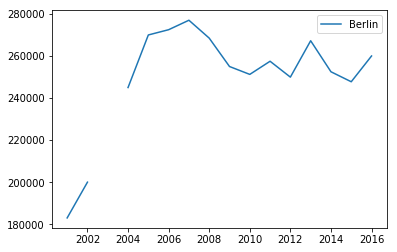

In [51]:
# Seasonally unadjusted median sale amount for Berlin
median_timeseries("SaleAmount", "Berlin").plot()

In [52]:
berlin_saleamount_ts = median_timeseries("SaleAmount", "Berlin")

### Identify surge in 2014 sales of homes, properties <\$100,000

In [53]:
sales_under_100k_ts = sale_count_timeseries_all_towns(source_df = df[df['SaleAmount'] < 100000])

In [54]:
homes_under_100k_useable = use_df[use_df['SaleAmount'] < 100000]

In [55]:
# Only transactions without NonUseCodes
num_sales = []
for year in range(2001, 2017):
    print(str(year) + ": " + str(len(homes_under_100k_useable[homes_under_100k_useable['Year'] == str(year)])))
    num_sales += [len(homes_under_100k_useable[homes_under_100k_useable['Year'] == str(year)])]

2001: 2040
2002: 7067
2003: 5266
2004: 5473
2005: 4304
2006: 2424
2007: 1393
2008: 1019
2009: 1172
2010: 1286
2011: 1225
2012: 1371
2013: 1566
2014: 3733
2015: 7229
2016: 2158


In [56]:
homes_under_100k_all = df[df['SaleAmount'] < 100000]

In [57]:
# ALL transactions-- whether or not they have NonUseCodes
num_sales = []
for year in range(2001, 2017):
    print(str(year) + ": " + str(len(homes_under_100k_all[homes_under_100k_all['Year'] == str(year)])))
    num_sales += [len(homes_under_100k_all[homes_under_100k_all['Year'] == str(year)])]

2001: 3685
2002: 13360
2003: 10170
2004: 10934
2005: 9353
2006: 5457
2007: 4145
2008: 3905
2009: 5377
2010: 6280
2011: 4967
2012: 5909
2013: 6327
2014: 8005
2015: 9086
2016: 8192


### Create a timeseries of monthly medians for the state, and seasonally adjust these values

In [24]:
import statsmodels.api as sm

In [182]:
def return_valid_months(df, minyear=MIN_YEAR, maxyear=MAX_YEAR):
    """
    Given a df of sales transactions, this will return a list of unique YearMonths (df['YearMonth']) and ensure that these
    are all formatted properly and make sense (i.e. no year less than MIN_YEAR or greater than MAX_YEAR)
    """
    months = list(df['YearMonth'].unique())
    
    # Remove wonky YearMonths
    for month in months:
        # Should have the format YYYY-MM at this point
        if len(str(month)) != 7:
            months.remove(month)
    
    # Sort chronologically and reconvert to datetime
    months = sorted(months)
    map(lambda x: pd.to_datetime(x), months)
    
    return months

In [286]:
def calculate_seasonal_adjustments(timeseries_df):
    """
    Given a timeseries, this will return a dataframe of its seasonally adjusted values.
    A HELPER FUNCTION for monthly_median_timeseries()
    """
    import statsmodels.api as sm
    sa = sm.tsa.seasonal_decompose(x=timeseries_df, model='additive', freq=12)
    return sa.trend

In [292]:
def calculate_monthly_medians(df, list_of_months, column):
    """
    Calculates a median of 'column' for each month in 'list_of_months' and returns this as a dataframe.
    """
    monthly_medians = {}
    for month in list_of_months:
        
        # Grab all the sales with this month
        month_sales = df[df['YearMonth'] == month]
        
        # Calculate the median and store in the dictionary
        median = month_sales[column].median()
        monthly_medians[month] = median
    
    # Now make this into a dataframe to return
    ts = pd.DataFrame(columns = [str(column)], index=monthly_medians.keys())
    for index in ts.index:
        ts.loc[index, str(column)] = monthly_medians[index]

    # Convert type to int
    ts[column] = ts[column].astype(dtype=int, errors='ignore')
    
    return ts

In [289]:
def monthly_median_timeseries(column, town='Connecticut', minyear=MIN_YEAR, maxyear=MAX_YEAR, source_df=res_df):
    """
    Returns a monthly time series with 3 columns: one for the month (in YYYY-MM format), one for the median of 'column'
    in source_df, and one for the seasonall adjusted value of each median.
    """
    # Grab just the 'town' you are interested in
    if town != 'Connecticut':
        subset = source_df[source_df['Town'] == town]
    else:
        subset = source_df
    
    # Grab just the 'YearMonth' and 'column' columns for this subset
    subset = subset[['YearMonth', column]].sort_values('YearMonth', ascending=True)
    
    # Get an ordered, valid list of months. Catches any errors such as NaN months or months of the wrong format
    months = return_valid_months(subset, minyear, maxyear)
    
    # Calculate monthly medians and create a timeseries for them
    ts = calculate_monthly_medians(subset, months, column)
    
    # Calculate seasonal adjustments
    sa = calculate_seasonal_adjustments(ts)
    
    # Merge and fix columns
    ts = pd.merge(left=ts, right=sa, on = ts.index)
    ts.columns = ['Month', column, 'SeasonallyAdjusted']
    
    ts.index = pd.to_datetime(ts.index, yearfirst=True) # Convert index back to DateTime
    return ts

In [290]:
ct_monthly_ts = monthly_median_timeseries('SaleAmount', 'Connecticut')

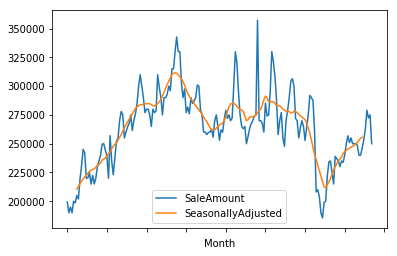

In [291]:
ct_monthly_ts.plot(x='Month', y=['SaleAmount', 'SeasonallyAdjusted'])